### 개요

* 머신러닝 모델은 특정한 분야에 있어서 매우 효과적입니다.
* 다양한 연구 결과에서 머신러닝 모델은 빠르고, 정확하며, 효과적이라는 것을 알려주었습니다.
* 하지만 자주 모델의 보안성과 견고성 측면이 간과되곤 합니다.
* 특히 모델을 멍청하게 만들기를 희망하는 적대적인 위협을 마주하게 될 수 있습니다.
* 사람의 눈으로 감지할 수 없는 노이즈를 추가한 Adversarial Example을 이용하면 모델의 성능을 비약적으로 떨어뜨리게 됩니다.
* 본 문서에서는 가장 대표적인 Adversarial Attack 방법인 Fast Gradient Sign Attack (FGSM)에 대해서 소개합니다.

### 위협적인 모델

* Adversarial Attack에는 다양한 종류가 있으며, 공격자의 사전 지식에 따라서 다르게 적용됩니다.
* 하지만 일반적인 목표는 Input Data에 최소한의 노이즈를 주어 오분류를 만들어 내는 것입니다.
* 공격자의 사전 지식에 따른 분류: White-box 공격 / Black-box 공격
* 공격자의 목표에 따른 분류: Misclassification / Source/Target Misclassification
* White-box 공격: 모델의 구조, 입력, 출력, 가중치를 포함하여 모델에 대한 모든 정보를 가지고 있는 경우
* Black-box 공격: 모델의 구조와 가중치에 대한 정보는 모르며 오직 입력과 출력에 대한 정보만 가지고 있는 경우
* Misclassification: 기존의 Input Data의 클래스와 다르게만 분류하면 되는 경우
* Source/Target Misclassification: 특정한 클래스로 분류하면 되는 경우

### Fast Gradient Sign Attack

* Ian Goodfellow가 제시한 가장 먼저 만들어진 방법이자 유명한 방법
* 직관적이며 매우 강력합니다.
* Gradient를 활용하여 학습하는 Neural Networks를 공격하도록 설계되었습니다.
* 역전파된 Gradient에 기반하여 Weight을 조정함으로써 비용을 최소화하는 방법 말고, 역전파된 Gradient를 기반으로 비용을 최대화하는 방법을 이용합니다.
* 다시 말해 비용을 최대화하도록 Input Data를 조정합니다.
![대체 텍스트](https://pytorch.org/tutorials/_images/fgsm_panda_image.png)

* 원래 이미지는 Panda로 분류됩니다.
* θ: 모델의 파라미터 
* x: 입력 이미지 데이터
* y: x에 대한 원래 결과
* J(θ, x, y)의 기울기에 0.007(ϵ )를 곱하여 sign(부호)의 방향으로 이동하여 비용을 최대화합니다.
* 결과적으로 perturbed image인 x'는 Panda가 아닌 Gibbon으로 분류되도록 합니다.

### 구현 시작

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

### 입력
* Epsilons: 실행을 위한 Epsilon 값 리스트입니다. Epsilon이 0이면, 원래 모델과 동일하게 동작합니다. Epsilon 값이 커지면 Perturbation이 더욱 부각되어 효과적으로 공격하므로 모델의 정확도를 떨어뜨립니다.
* 예제에서 데이터의 범위는 [0, 1]이므로 Epsilon은 1을 초과할 수 없습니다.
* Pretrained Model: 사전 학습된 MNIST 모델의 경로입니다. [다운로드](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing)해서 CoLab에 업로드 할 수 있습니다.
* Use Cuda: CUDA 사용 여부입니다. 이번 튜토리얼에서는 CPU를 이용할 때에도 빠르게 동작하므로 GPU with CUDA는 그다지 필요하지 않습니다.

In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving lenet_mnist_model.pth to lenet_mnist_model.pth
User uploaded file "lenet_mnist_model.pth" with length 88724 bytes


In [0]:
epsilons = [0.1, 0.2, 0.3]
pretrained_model = "lenet_mnist_model.pth"
use_cuda=True

### 공격 받는 모델
* 이번 절의 목표는 모델과 Data Loader를 정의합니다.
* 이후에 모델을 초기화하고, 사전 학습 가중치를 불러옵니다.

In [0]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset and dataloader declaration
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA Available:  True


In [0]:
# Initialize the network
model = Net().to(device)

# Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [0]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [0]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [0]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.2	Test Accuracy = 4303 / 10000 = 0.4303
Epsilon: 0.3	Test Accuracy = 871 / 10000 = 0.0871


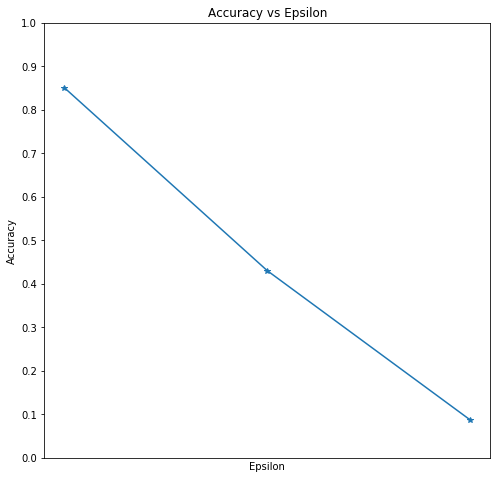

In [0]:
plt.figure(figsize=(8,8))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(1, .35, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

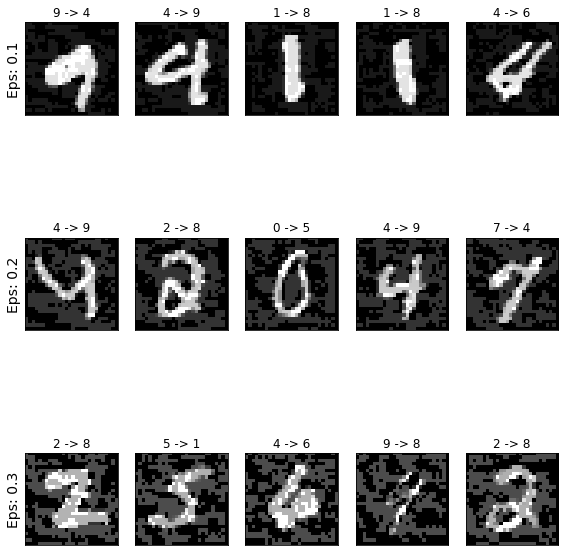

In [0]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()